# How to use the Kalman Filter and Wavelets

## Imports & Settings

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
%matplotlib inline

from datetime import datetime
import itertools

import pandas as pd
import pandas_datareader.data as web
from pykalman import KalmanFilter
import pywt

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [13]:
DATA_STORE = '/Users/yangchenxi/Desktop/04_alpha_factor_research/assets.h5'

In [14]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].loc['2009': '2010', 'close']

In [15]:
sp500

Date
2009-01-02     931.80
2009-01-05     927.45
2009-01-06     934.70
2009-01-07     906.65
2009-01-08     909.73
               ...   
2010-12-27    1257.54
2010-12-28    1258.51
2010-12-29    1259.78
2010-12-30    1257.88
2010-12-31    1257.64
Name: close, Length: 504, dtype: float64

## Kalman Filter 

### Configuration

In [16]:
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
#kf的初始化

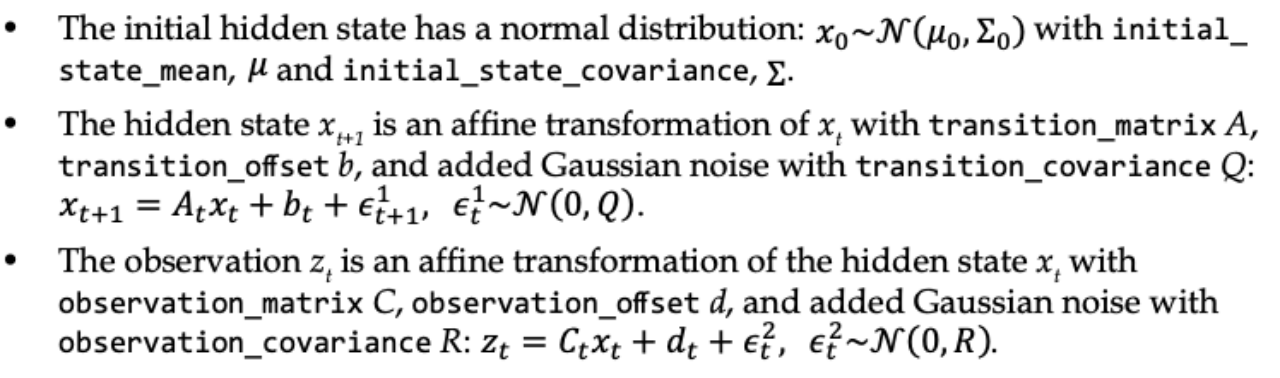

### Estimate the hidden state

In [17]:
state_means, _ = kf.filter(sp500)

In [21]:
state_means

array([[ 465.9       ],
       [ 621.78774834],
       [ 702.52590536],
       [ 745.67161011],
       [ 775.40674557],
       [ 793.86016349],
       [ 804.99132608],
       [ 813.99048799],
       [ 817.60995796],
       [ 820.74679327],
       [ 824.12709476],
       [ 822.02509471],
       [ 823.99373868],
       [ 824.36403005],
       [ 825.15015111],
       [ 826.31536742],
       [ 828.26932165],
       [ 832.83787725],
       [ 834.05406133],
       [ 833.25159208],
       [ 832.48907497],
       [ 833.0740561 ],
       [ 832.99236282],
       [ 834.23291172],
       [ 837.54025936],
       [ 840.64692384],
       [ 839.35395408],
       [ 838.8165119 ],
       [ 838.46973482],
       [ 837.3587187 ],
       [ 832.75869993],
       [ 828.52888087],
       [ 823.80066119],
       [ 818.67780092],
       [ 811.49906305],
       [ 807.84545706],
       [ 803.75596294],
       [ 798.90744942],
       [ 792.83252545],
       [ 784.07477208],
       [ 775.72409965],
       [ 769.742

In [19]:
len(state_means)

504

### Compare with moving average

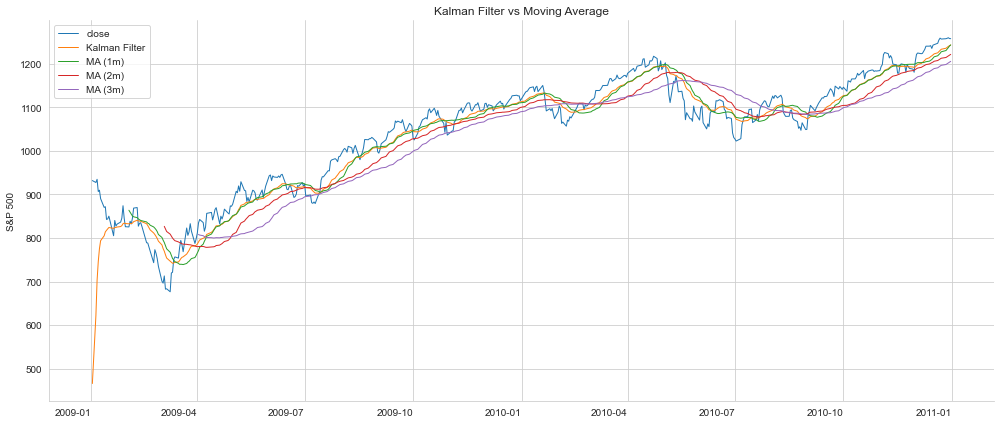

In [22]:
sp500_smoothed = sp500.to_frame('close')
sp500_smoothed['Kalman Filter'] = state_means
for months in [1,2,3]:
    sp500_smoothed[f'MA ({months}m)'] = sp500.rolling(window=months*21).mean()

ax = sp500_smoothed.plot(title='Kalman Filter vs Moving Average', figsize=(14,6), lw=1, rot=0)
ax.set_xlabel('')
ax.set_ylabel('S&P 500')
plt.tight_layout()
sns.despine();

## Wavelets

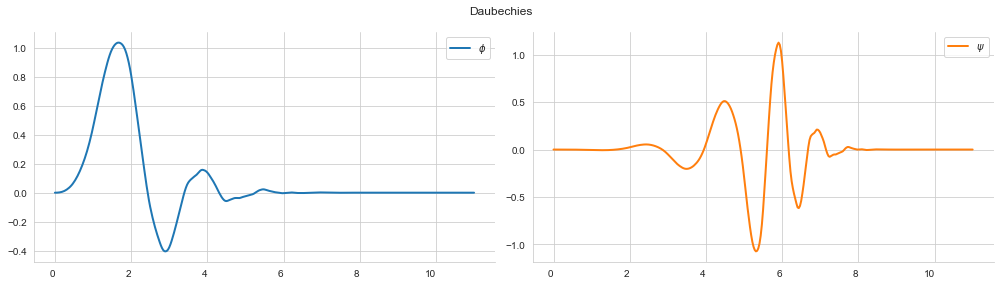

In [23]:
wavelet = pywt.Wavelet('db6')
phi, psi, x = wavelet.wavefun(level=5)
df = pd.DataFrame({'$\phi$': phi, '$\psi$': psi}, index=x)
df.plot(title='Daubechies', subplots=True, layout=(1, 2), figsize=(14, 4), lw=2, rot=0)
plt.tight_layout()
sns.despine();

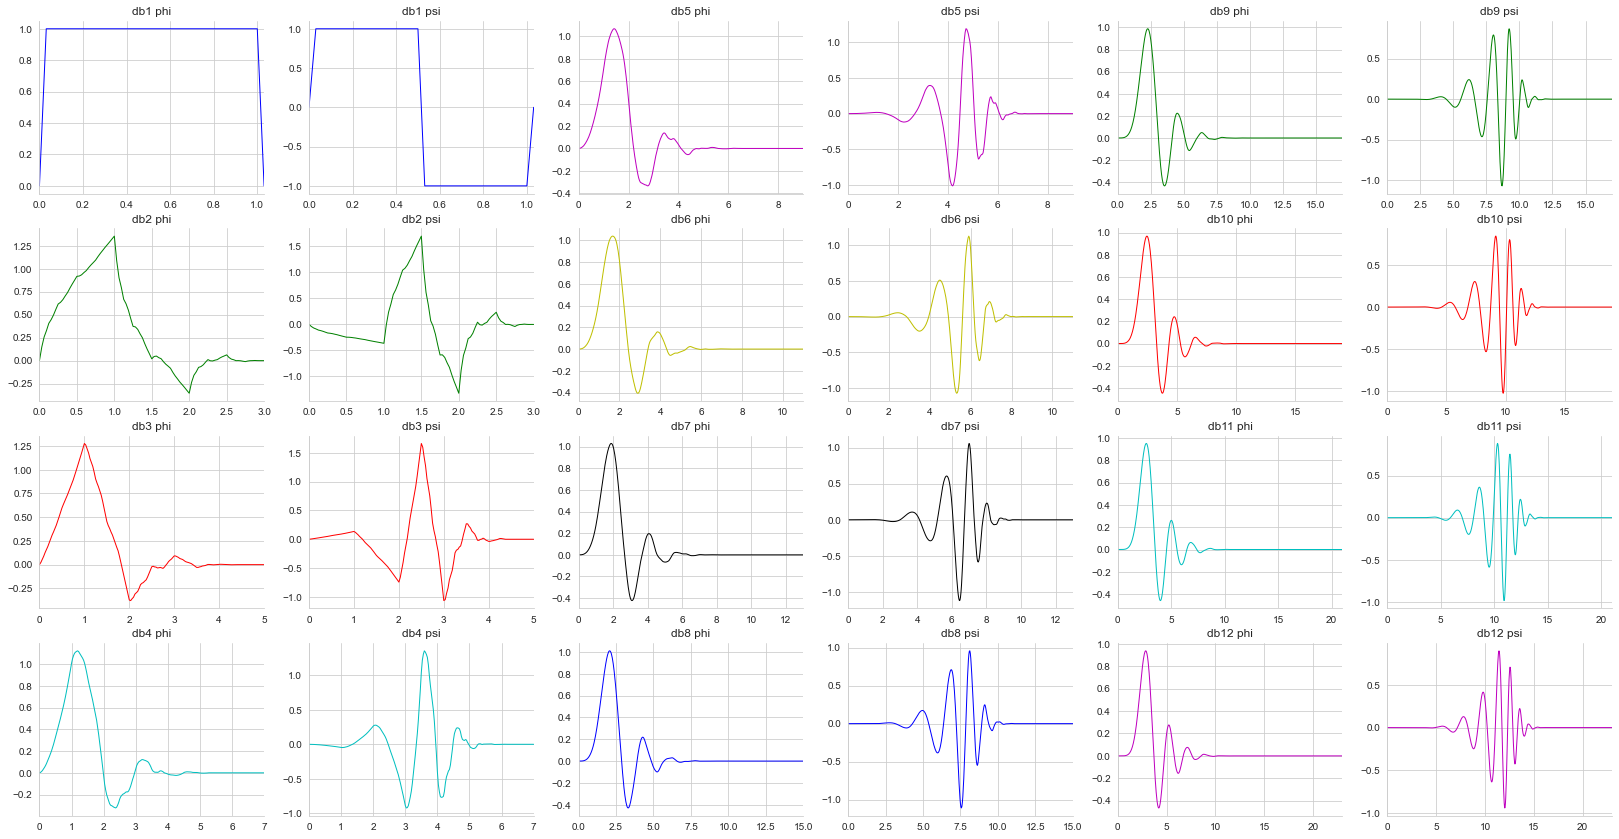

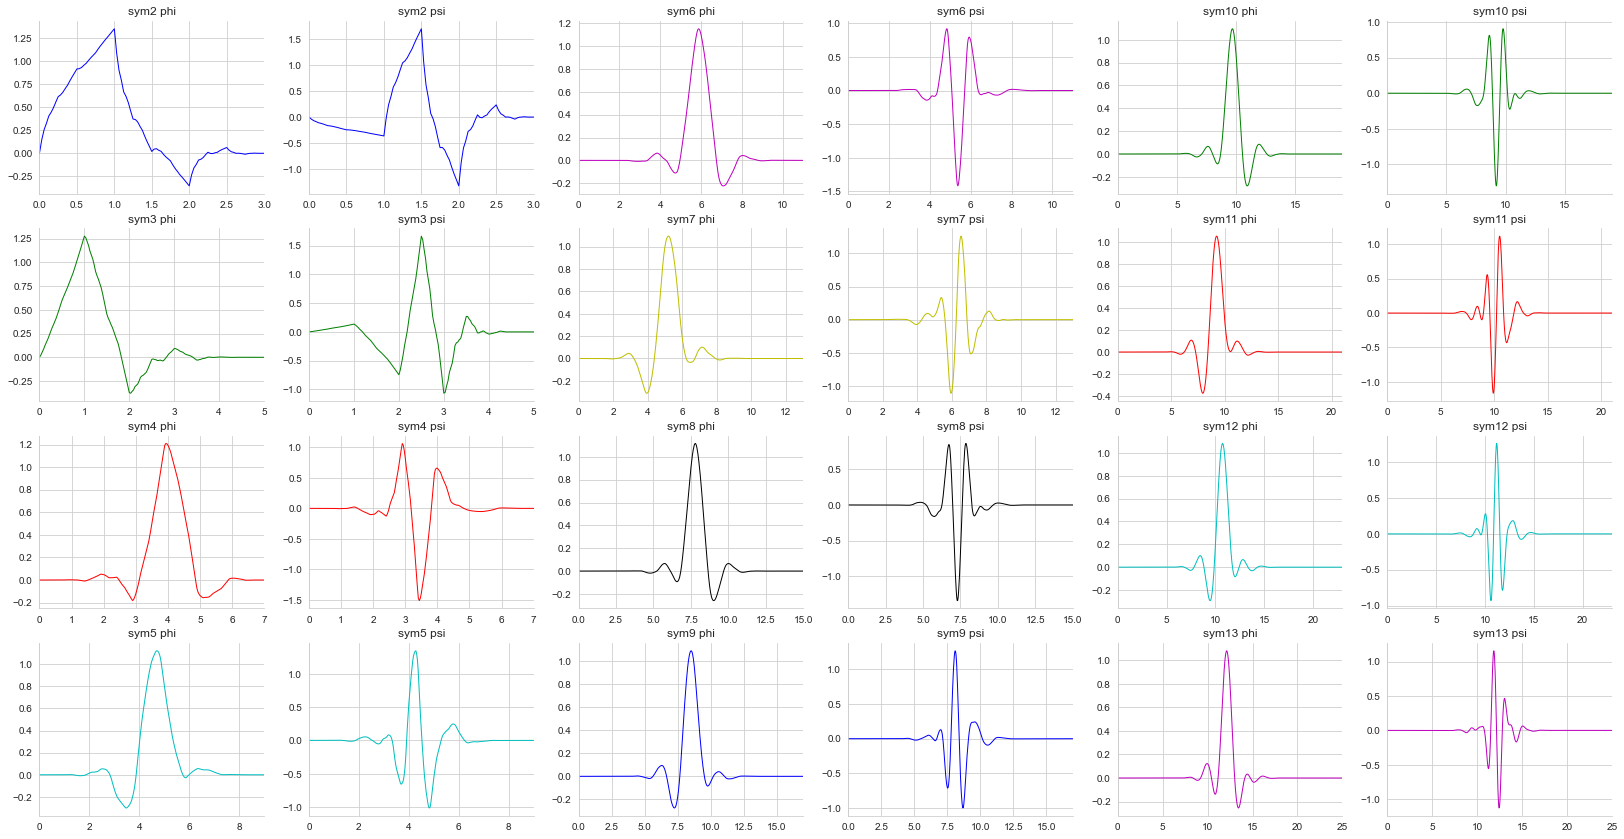

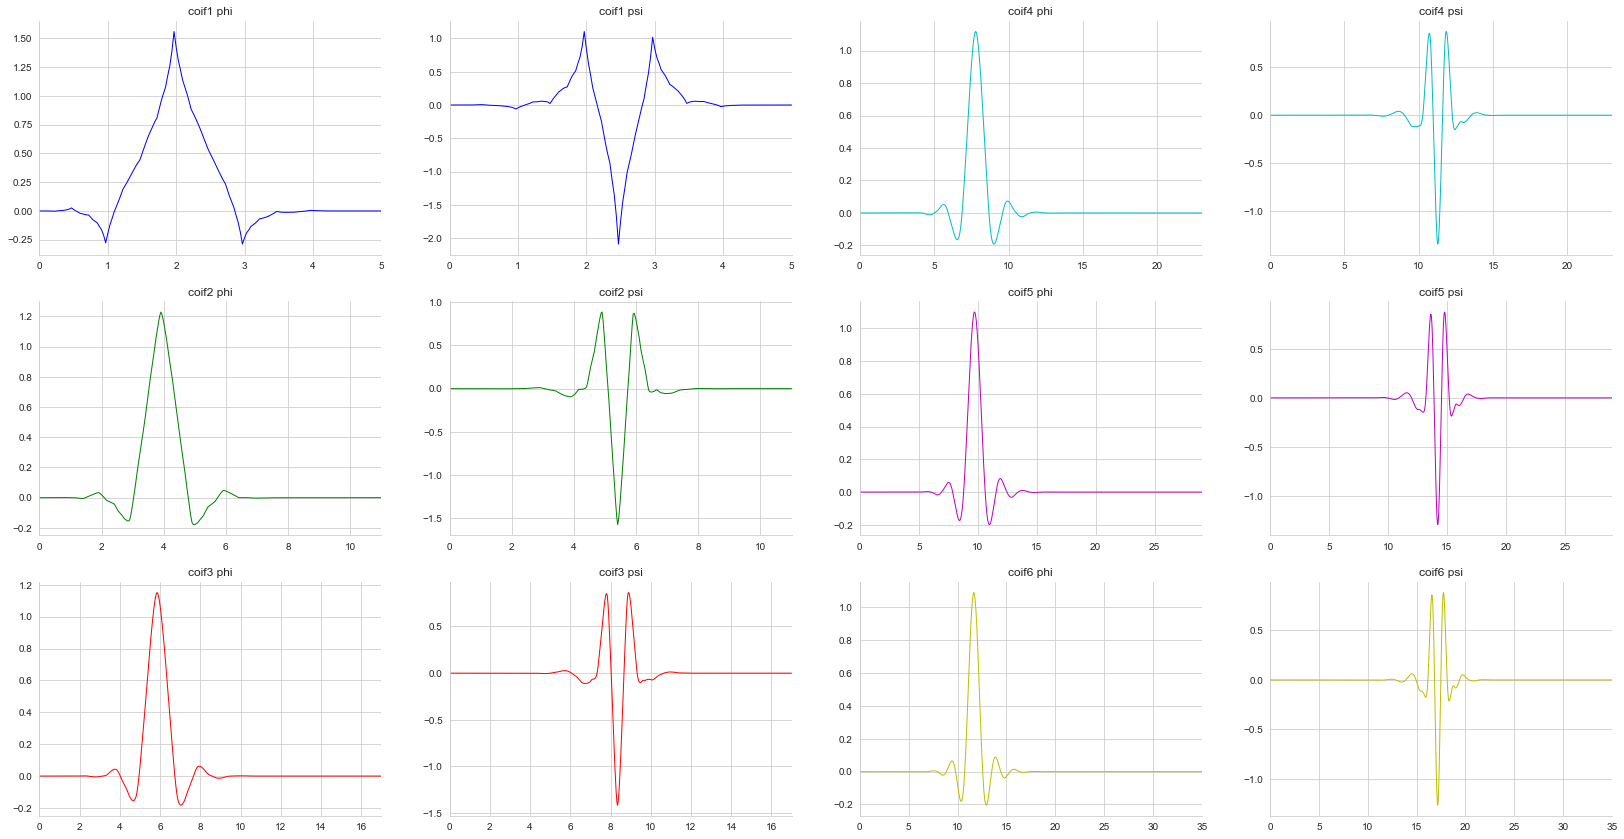

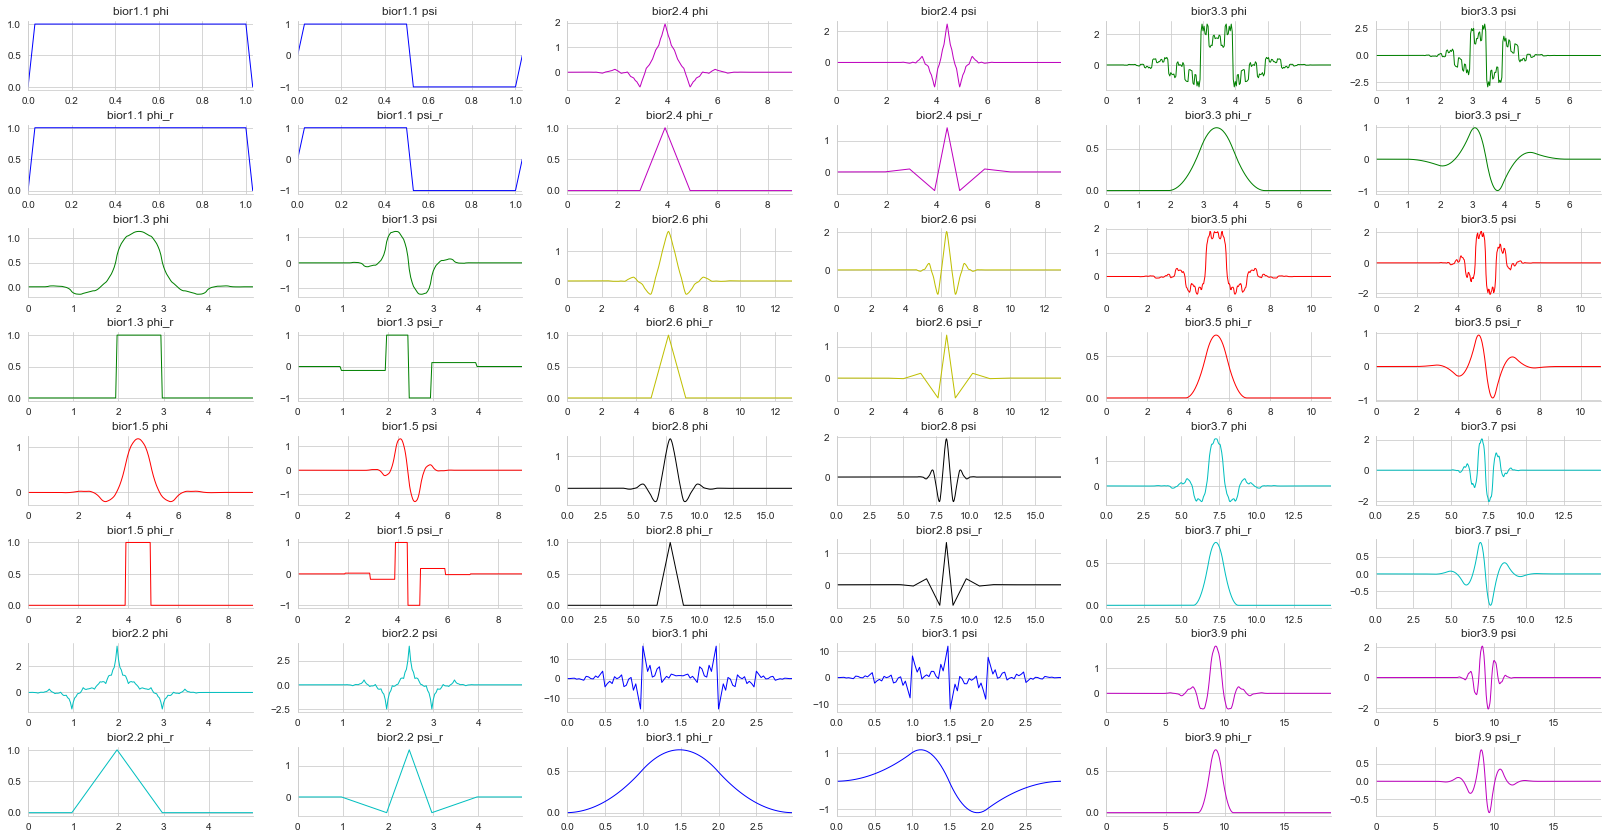

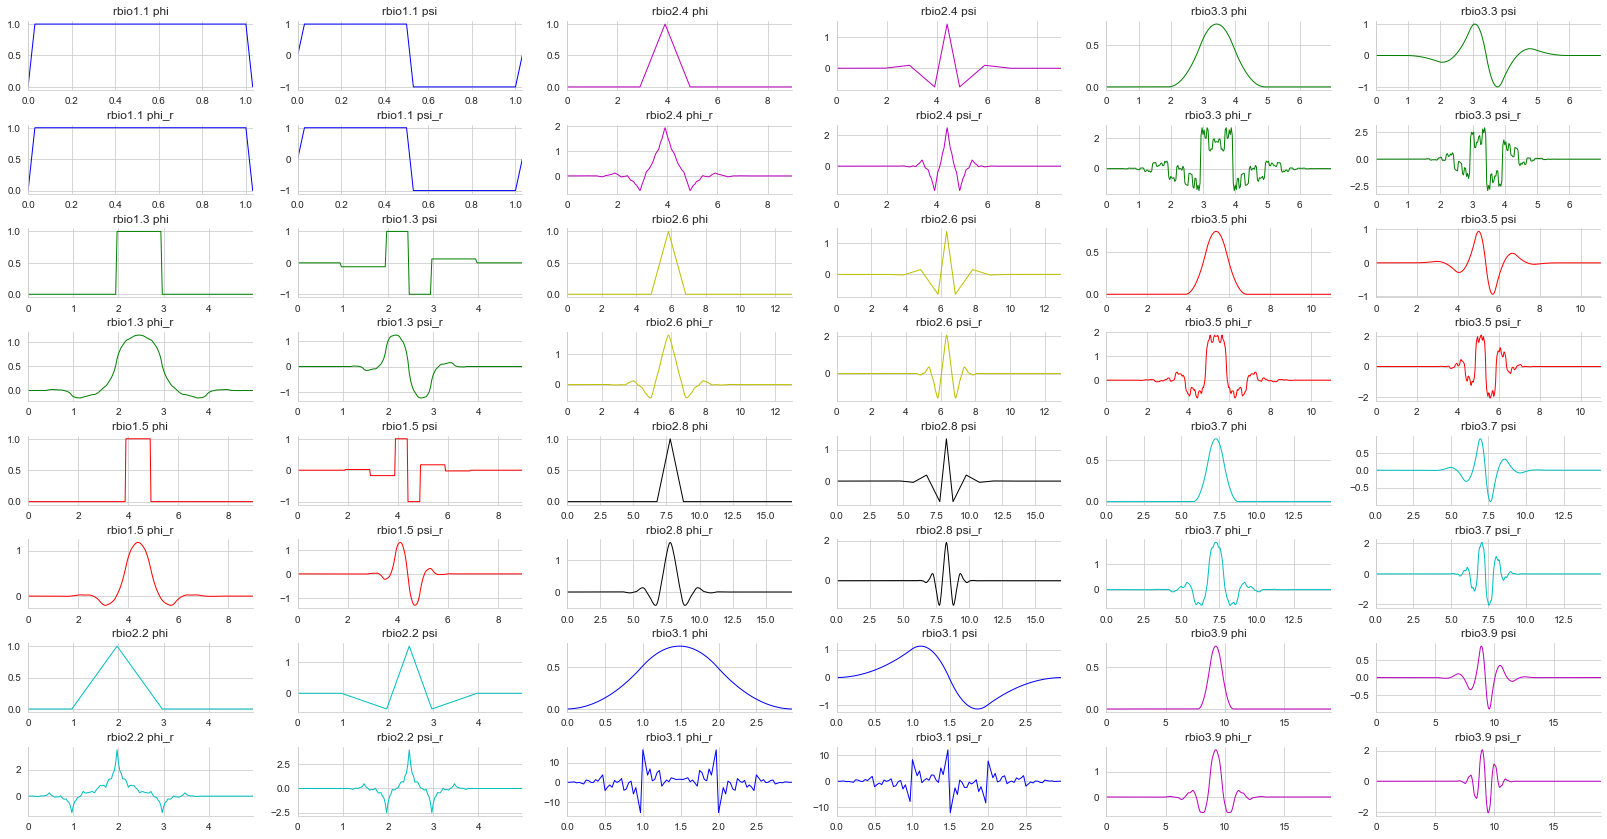

In [24]:
plot_data = [('db', (4, 3)),
             ('sym', (4, 3)),
             ('coif', (3, 2))]


for family, (rows, cols) in plot_data:
    fig = plt.figure(figsize=(24, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)
    colors = itertools.cycle('bgrcmyk')

    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, x = wavelet.wavefun(level=5)

            color = next(colors)
            ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color, lw=1)
            ax.set_xlim(min(x), max(x))
    sns.despine()

for family, (rows, cols) in [('bior', (4, 3)), ('rbio', (4, 3))]:
    fig = plt.figure(figsize=(24, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)

    colors = itertools.cycle('bgrcmyk')
    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
            row *= 2

            color = next(colors)
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color, lw=1)
            ax.set_xlim(min(x), max(x))

            row += 1
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi_r")
            ax.plot(x, phi_r, color, lw=1)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi_r")
            ax.plot(x, psi_r, color, lw=1)
            ax.set_xlim(min(x), max(x))
    sns.despine()

plt.show()

### Available Wavelet Families

In [25]:
pywt.families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

### Smoothing the S&P 500

In [30]:
signal = (pd.read_hdf(DATA_STORE, 'sp500/stooq')
          .loc['2008': '2009']
          .close.pct_change()
          .dropna())
signal

Date
2008-01-03    0.000000
2008-01-04   -0.024552
2008-01-07    0.003223
2008-01-08   -0.018352
2008-01-09    0.013624
                ...   
2009-12-24    0.005256
2009-12-28    0.001154
2009-12-29   -0.001401
2009-12-30    0.000195
2009-12-31   -0.010050
Name: close, Length: 504, dtype: float64

In [33]:
coefficients

[array([ 0.01659212,  0.00436353,  0.0123266 , -0.00294488, -0.01050028,
         0.00542103,  0.00659744, -0.02129731,  0.01305653, -0.04517786,
        -0.02058733,  0.00703665, -0.03062791,  0.02512112,  0.0117613 ,
         0.00742356]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.0058361 ,
         0.        ,  0.        ,  0.00908332,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.   

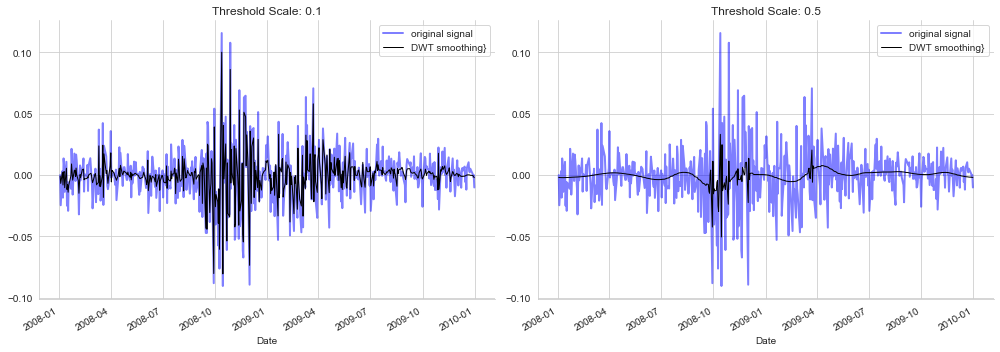

In [26]:
signal = (pd.read_hdf(DATA_STORE, 'sp500/stooq')
          .loc['2008': '2009']
          .close.pct_change()
          .dropna())

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

wavelet = "db6"
for i, scale in enumerate([.1, .5]):#两次循环，分别是threshold为0.1和0.5
    
    coefficients = pywt.wavedec(signal, wavelet, mode='per')
    #.wavedec函数对返回信号进行分解，得到小波变换的系数

    '''
    wavedec()函数完成1D多阶次离散小波分解,
    返回系数数组list，[cAn, cDn, cDn-1, …, cD2, cD1]，n为分解阶次，cAn是逼近系数数组，后面的依次是细节系数数组。
    
    wavedec(data, wavelet, mode=’sym’, level=None)
    data :　输入信号
    wavelet: 可以是来自wavelist()的小波名称，也可以是Wavelet对象。
    mode: 信号拓展模式
    '''
    
    
    coefficients[1:] = [pywt.threshold(i, value=scale*signal.max(), mode='soft') for i in coefficients[1:]]
    #我们过滤掉所有高于给定阈值的系数
    
    '''
    pywt.threshold (data, value, mode=, substitute=)
    data: 输入的数据
    value： 阈值
    mode： 阈值函数的类型 ，API提供四种类型（soft hard greater less），具体实现效果可以参考API的实例来理解
    substitute： 要替换的值（经阈值函数处理后的值）
    '''
    
    
    #用反变换.waverec只用这些系数来重建信号
    reconstructed_signal = pywt.waverec(coefficients, wavelet, mode='per')
    signal.plot(color="b", alpha=0.5, label='original signal', lw=2, 
                 title=f'Threshold Scale: {scale:.1f}', ax=axes[i])
    pd.Series(reconstructed_signal, index=signal.index).plot(c='k', label='DWT smoothing}', linewidth=1, ax=axes[i])
    axes[i].legend()
fig.tight_layout()
sns.despine();